In [1]:
import astropy.io.fits
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import factorial
import scipy.interpolate

In [2]:
gain = 5.5
R = 13

In [3]:
hdul = astropy.io.fits.open("ERS_NGTS10_2022_seg_038.fits")
#Assumptions for dark current subtraction
assert(hdul[0].header["NFRAMES"] == 1)
assert(hdul[0].header["GROUPGAP"] == 0)

In [4]:
hdul[1].data.shape

(44, 300, 416, 72)

In [5]:
for i in range(1, len(hdul)):
    print(hdul[i].header["EXTNAME"], hdul[i].data.shape)
data = hdul[1].data

SCI (44, 300, 416, 72)
PIXELDQ (416, 72)
REFOUT (44, 300, 416, 18)
ASDF (1,)


In [13]:
hdul[2].data.shape

(416, 72)

In [15]:
%matplotlib qt
plt.imshow(hdul[2].data != 0)


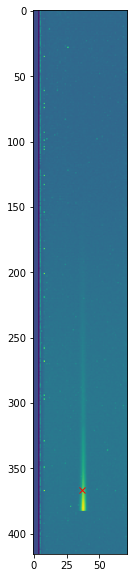

In [6]:
y = 367
#y = 382
x = 37

plt.figure(figsize=(10,10))
plt.imshow(data[0,-1])
plt.plot(x, y, 'x', color='r')

[  14.38024498 2106.22049562]
manual fit 14.380244978796206


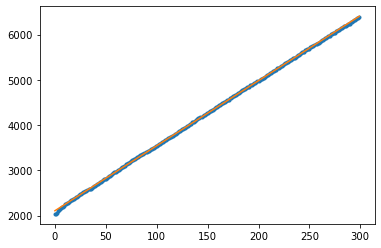

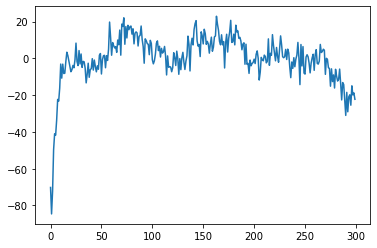

In [7]:
%matplotlib inline
xs = np.arange(data.shape[1])


#y = 367
#x = 1

coeffs = np.polyfit(xs, data[0,:,y,x], 1)
print(coeffs)
n = 300
print("manual fit", 12*np.sum(((xs+1) - (300+1)/2)*data[0,:,y,x]) / n / (n**2-1))

#coeffs[0] = 3.016
predicted = np.polyval(coeffs, xs)
residuals = data[0,:,y,x] - predicted

plt.plot(xs, data[0,:,y,x], '.')
plt.plot(xs, predicted)
#plt.xlim(0, 6)
#plt.ylim(2000,2200)
plt.figure()
plt.plot(xs, residuals)
plt.show()

37
(300,)


(1900.0, 2200.0)

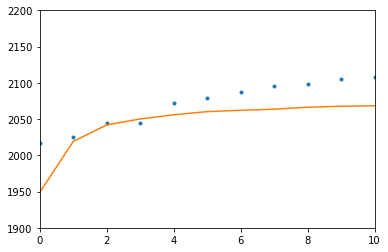

In [8]:
print(x)
master_ref = np.mean(data[0,:,:,0:4], axis=(1,2))
master_ref = np.mean(data[0,:,:,3], axis=1)
print(master_ref.shape)

plt.plot(xs, data[0,:,y,x-3], '.')
#plt.plot(xs, data[0,:,y,-1], '.')
plt.plot(xs, master_ref)
plt.xlim(0, 10)
plt.ylim(1900, 2200)

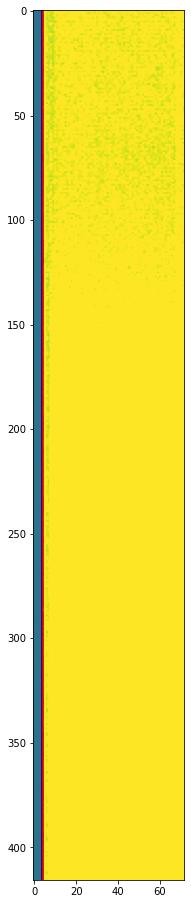

In [9]:
%matplotlib inline
plt.figure(figsize=(16,16))
plt.imshow(data[0,-1], vmin=1500, vmax=3000)
plt.axvline(4, color='r')
plt.show()

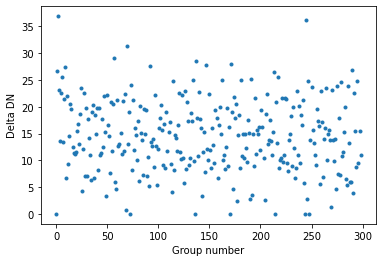

In [10]:
plt.plot(np.diff(np.array(data[0,:,y,x], dtype=float)), '.')
plt.xlabel("Group number")
plt.ylabel("Delta DN")
plt.savefig("group_values.png")

14.540594


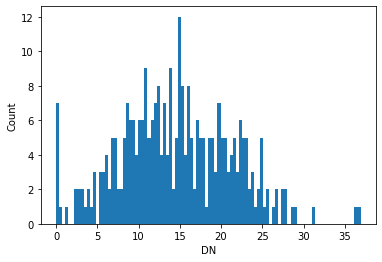

In [11]:
diffs = np.diff(data[0,:,y,x])
print(np.mean(diffs))
_ = plt.hist(diffs, bins=100)
plt.xlabel("DN")
plt.ylabel("Count")
plt.savefig("group_hist.png")

In [12]:
print(np.sum(diffs == 0), np.sum(diffs > 0))

7 292


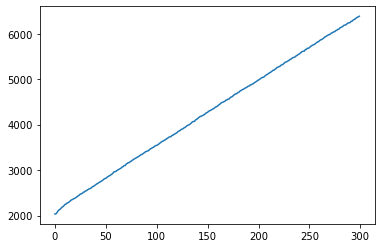

In [13]:
plt.plot(data[0,:,y,x])


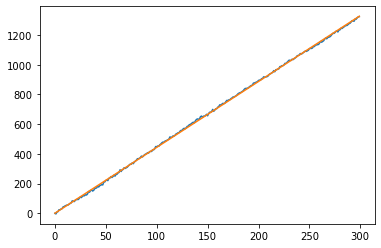

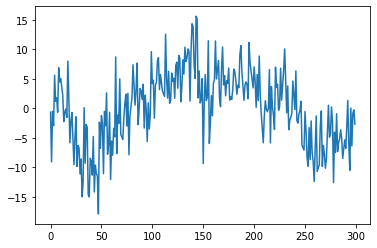

In [14]:
#Simulate the process
RN = 20
gain = 5.5
electrons_per_int = 24
N_groups = 300

xs = np.arange(N_groups)
electrons = np.zeros(N_groups)
measured = np.zeros(N_groups)

for i in range(1, N_groups):
    arrived = np.random.normal(electrons_per_int, np.sqrt(electrons_per_int))
    electrons[i] = electrons[i-1] + arrived
    measured[i] = np.floor(np.random.normal(electrons[i], RN) / gain)
    
#plt.plot(xs, measured)  
coeffs = np.polyfit(xs, measured, 1)
predicted = np.polyval(coeffs, xs)
residuals = measured - predicted    

plt.plot(xs, measured)
plt.plot(xs, predicted)
plt.figure()
plt.plot(xs, measured - predicted)

(array([ 3.,  4., 14., 46., 60., 70., 64., 24., 11.,  3.]),
 array([-13. ,  -9.7,  -6.4,  -3.1,   0.2,   3.5,   6.8,  10.1,  13.4,
         16.7,  20. ]),
 <a list of 10 Patch objects>)

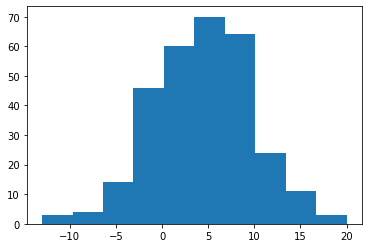

In [15]:
plt.hist(np.diff(measured))

In [16]:
print(np.std(np.diff(measured)))
print(np.std(diffs))

5.373369506507923
6.768636


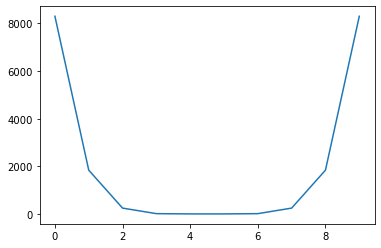

In [17]:
i = np.arange(10)
plt.plot(i, (i-4.5)**6)

[[0.     0.0276 0.    ]
 [0.0316 0.8816 0.0316]
 [0.     0.0276 0.    ]]
3


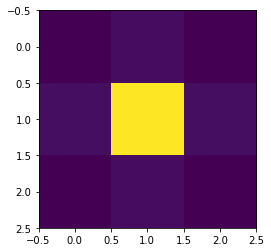

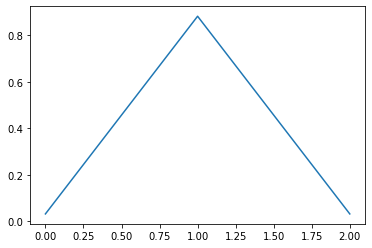

In [18]:
%matplotlib inline
ipc = astropy.io.fits.open("jwst_miri_ipc_0009.fits")
print(ipc[1].data)
plt.imshow(ipc[1].data)
plt.figure()
plt.plot(ipc[1].data[1])
print(len(ipc))

In [19]:
linearity = astropy.io.fits.open("jwst_miri_linearity_0014.fits")
print(linearity[1].data.shape)
#plt.imshow(linearity[1].data)

(4, 1024, 1032)


(416, 72) (44, 300, 416, 72)
(416, 72) (44, 300, 416, 72)
(416, 72) (44, 300, 416, 72)
(416, 72) (44, 300, 416, 72)
(416, 72) (44, 300, 416, 72)


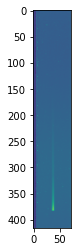

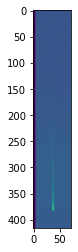

In [20]:
def apply_nonlinearity(data, filename="jwst_miri_linearity_0024.fits", slitless_left=0, slitless_right=72, slitless_top=528, slitless_bot=944):
    data_float = np.array(data, dtype=float)
    with astropy.io.fits.open(filename) as hdul:
        coeffs = hdul[1].data[:, slitless_top:slitless_bot, slitless_left:slitless_right]
        result = np.zeros(data.shape)
        exp_data = np.ones(data.shape)
        
        for i in range(len(coeffs)):
            print(coeffs[i].shape, data.shape)            
            result += coeffs[i] * exp_data #data_float**i
            exp_data *= data_float
    return result


after_nonlinear = apply_nonlinearity(data)

plt.imshow(data[0,-1], vmin=0, vmax=1e4)
plt.figure()
plt.imshow(after_nonlinear[0,-1], vmin=0, vmax=1e4)

In [21]:
#Reset Switch Charge Decay (RSCD) Correction?  No idea how to do

(2, 1000, 416, 72)


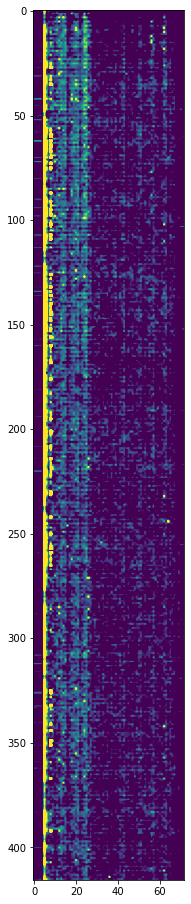

In [22]:
#Dark current subtraction
def subtract_dark(data, filename="jwst_miri_dark_0048.fits"):    
    with astropy.io.fits.open(filename) as dark_hdul:
        dark = dark_hdul[1].data
    print(dark.shape)
    N_int = data.shape[0]
    N_grp = data.shape[1]
    N_int_dark = dark.shape[0]
    N_grp_dark = dark.shape[1]
    
    assert(N_int > N_int_dark)
    assert(N_grp <= N_grp_dark)
    
    result = np.copy(data)
    result[:N_int_dark] -= dark[:, :N_grp]
    result[N_int_dark:] -= dark[-1, :N_grp]
    return result
    
after_dark = subtract_dark(after_nonlinear)

plt.figure(figsize=(16,16))
plt.imshow((after_nonlinear - after_dark)[0,-1], vmin=0, vmax=20)

In [23]:
after_gain = after_dark * gain

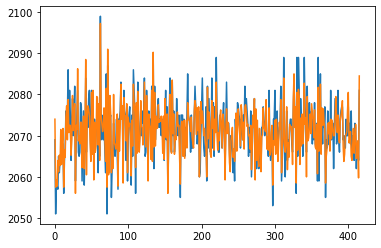

In [24]:
plt.plot(data[1,-1,:,1])
plt.plot(np.mean(data[1,-1,:,0:4], axis=1))

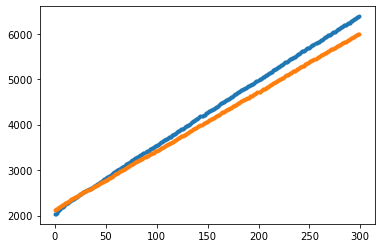

In [25]:
plt.plot(data[0,:,y,x], '.')
plt.plot(after_dark[0,:,y,x] + 300, '.')

[   71.1485842  10106.06121055]


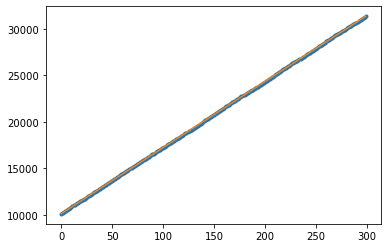

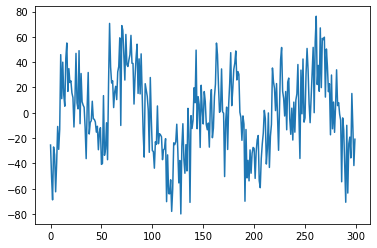

In [26]:
xs = np.arange(after_dark.shape[1])
coeffs = np.polyfit(xs, after_gain[0,:,y,x], 1)
print(coeffs)

predicted = np.polyval(coeffs, xs)
residuals = after_gain[0,:,y,x] - predicted

plt.plot(xs, after_gain[0,:,y,x], '.')
plt.plot(xs, predicted)
plt.figure()
plt.plot(xs, residuals)

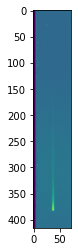

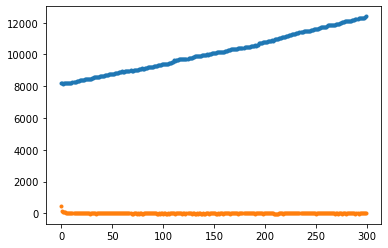

In [27]:
plt.imshow(after_gain[0,-1])
plt.figure()
plt.plot(after_gain[0,:,100,8] - 1800, '.')
plt.plot(after_gain[0,:,100,0], '.')

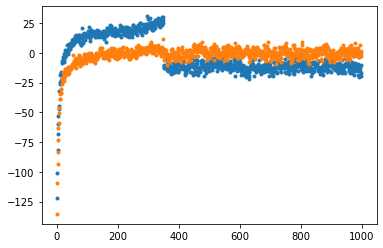

In [28]:
with astropy.io.fits.open("jwst_miri_dark_0048.fits") as dark_hdul:
    dark = dark_hdul[1].data

plt.plot(dark[0,:,100,8], '.')
plt.plot(dark[0,:,100,20], '.')

(299,)
True


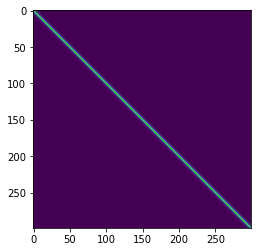

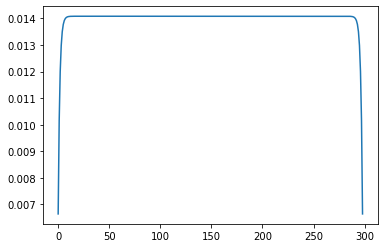

In [29]:
N_int = data.shape[1]
#print(N_int)
#K = np.zeros((N_int, N_int))

m = 71

K = np.diag((m + 2*R**2) * np.ones(N_int-1)) + np.diag(-R**2 * np.ones(N_int-2), -1) + np.diag(-R**2 * np.ones(N_int-2), 1)
#K += np.random.normal(0, 1e-2, K.shape)

inv_K = np.linalg.inv(K)
weights = np.sum(inv_K, axis=1)
print(weights.shape)
plt.imshow(inv_K)
plt.figure()
plt.plot(weights)


#Analytic weights
N = N_int - 1
l = np.arccosh(1 + m/R**2/2)
j = np.arange(1, N + 1)
analytic_weights = -R**-2 * np.exp(l) * (1 - np.exp(-j*l)) * (np.exp(j*l - l*N) - np.exp(l)) / (np.exp(l) - 1)**2 / (np.exp(l) + np.exp(-l*N))
print(np.allclose(weights, analytic_weights))

(299, 299)


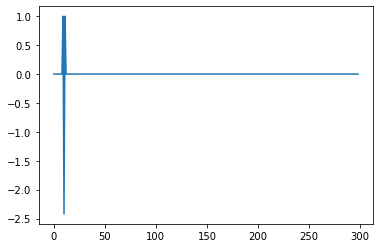

In [30]:
plt.plot(K[10] / -R**2)
print(K.shape)

Symmetric True
Col sums correct? True
Grand sum correct? True


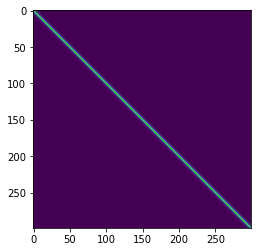

<Figure size 432x288 with 0 Axes>

In [31]:
#Try analytic inversion
l = np.arccosh((2 + m/R**2) / 2)
N_int = data.shape[1]
#print(N_int)

j, i = np.meshgrid(np.arange(1, N_int), np.arange(1, N_int))
#i, j = np.meshgrid(np.arange(N_int-1), np.arange(N_int-1))


#inverse = (np.cosh(l * (N + 1 - np.abs(j-i))) - np.cosh(l*(N+1-i-j))) / (2 * np.sinh(l) * np.sinh(l*(N + 1)))
inverse = R**-2 * (np.cosh(l * (N_int - np.abs(j-i))) - np.cosh(l*(N_int - i - j))) / (2 * np.sinh(l) * np.sinh(l*N_int))
#inverse = R**-2 * np.sinh(i*l) * np.sinh(l*(N_int - j)) / np.sinh(l) / np.sinh(l * N_int)

print("Symmetric", np.allclose(inverse, inverse.T))
plt.imshow(inverse)
#print(i, j.shape)

plt.figure()
#plt.plot(inverse[0])
#plt.plot(inv_K[0])

#print(l)
#print((2 + m/R**2)/2)

#print(inv_K[10,0:10])
#print(inverse[10,0:10])

#print(K.dot(inverse))
#print(K.dot(inv_K))
#print(K.shape, inverse.shape)

#print(np.allclose(inv_K, inverse))

a = np.exp(l)
j = np.arange(1, N_int)
N = N_int - 1
#col_sums = R**-2 * a**(1 - j) * (a**j - a**(2*j) + a**(1+j) + a**(1+2*j) + a**N_int + a**(j+N_int) + a**(1+j+N_int) - a**(1+N_int)) / ((a-1)**2 * (1+a) * (1+a**N_int))
col_sums = -R**-2 * np.exp(l) * (1 - np.exp(-j*l)) * (np.exp(j*l - l*N) - np.exp(l)) / (np.exp(l) - 1)**2 / (np.exp(l) + np.exp(-l*N)) #np.exp(l-l*j) * (np.exp(j*l) - 1) * (np.exp(j*l) - np.exp(l + l*N)) / (-1 + np.exp(l))**2 / (1 + np.exp(l + l*N))


print("Col sums correct?", np.allclose(col_sums, np.sum(inverse, axis=0)))
grand_sum = R**-2 * np.exp(l) * (-N*np.exp(-l*N) + np.exp(2*l)*N + np.exp(l-l*N)*(2+N) - np.exp(l)*(2+N)) / (np.exp(l) - 1)**3 / (np.exp(-l*N) + np.exp(l))
print("Grand sum correct?", np.allclose(grand_sum, np.sum(col_sums)))
#print(grand_sum)
#print(np.sum(col_sums), np.sum(inverse))

In [32]:
a = 2.3
matrix = np.array([[ a, -1, 0, 0],
                   [-1, a, -1, 0],
                   [0, -1,  a, -1],
                   [0,  0,  -1, a]]
                 )
N = matrix.shape[0]
inv = np.linalg.inv(matrix)
print("Numerical symmetric", np.allclose(inv, inv.T))

j, i = np.meshgrid(np.arange(1, N+1), np.arange(1, N+1))
#inverse = -R**-2 * (-np.cosh(l * (N_int - np.abs(j-i))) - np.cosh(l*(N_int - i - j))) / (2 * np.sinh(l) * np.sinh(l*N_int))

l = np.arccosh(a/2)
inverse = np.sinh(i*l) * np.sinh(l*(N + 1 - j)) / np.sinh(l) / np.sinh(l * (N + 1))
print("Analytic symmetric", np.allclose(inverse, inverse.T))
inverse = (np.cosh(l * (N + 1 - np.abs(j-i))) - np.cosh(l*(N+1-i-j))) / (2 * np.sinh(l) * np.sinh(l*(N + 1)))

print(inv)
print(inverse)

print(np.allclose(inv, inverse))

#print(j - i)

Numerical symmetric True
Analytic symmetric False
[[0.57701253 0.32712882 0.17538375 0.0762538 ]
 [0.32712882 0.75239628 0.40338262 0.17538375]
 [0.17538375 0.40338262 0.75239628 0.32712882]
 [0.0762538  0.17538375 0.32712882 0.57701253]]
[[0.57701253 0.32712882 0.17538375 0.0762538 ]
 [0.32712882 0.75239628 0.40338262 0.17538375]
 [0.17538375 0.40338262 0.75239628 0.32712882]
 [0.0762538  0.17538375 0.32712882 0.57701253]]
True


In [33]:
np.sinh(i*l) * np.sinh(l*(N_int - j)) / np.sinh(l * N_int)

array([[0.33057446, 0.19243042, 0.11201551, 0.06520526],
       [0.76032126, 0.44258997, 0.25763568, 0.14997209],
       [1.41816443, 0.82552651, 0.48054655, 0.27973055],
       [2.50145694, 1.45612101, 0.84762139, 0.49340818]])

0 0.01
10 0.025353644939701114
20 0.06428073117284322
30 0.16297508346206444
40 0.41320124001153385
50 1.0476157527896652
60 2.656087782946687
70 6.7341506577508286
80 17.07352647470692
90 43.287612810830616
0.10558032989501953


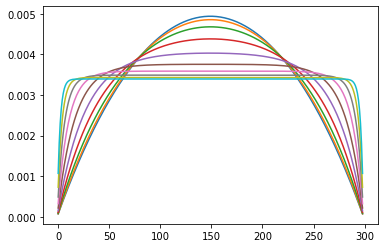

In [34]:
#construct library of weights
import time
R = 13
N_int = 300
all_ratios = np.logspace(-2, 2, 100)
all_weights = []
all_weight_norms = []

start = time.time()
for i, signal_over_read_var in enumerate(all_ratios):
    m = signal_over_read_var * R**2 / (N_int - 1)
    K = np.diag((m/R**2 + 2) * np.ones(N_int-1)) + np.diag(-np.ones(N_int-2), -1) + np.diag(-np.ones(N_int-2), 1) 
    inv_K = np.linalg.inv(K)
    weights = np.sum(inv_K, axis=1)
    #print(weights)
    all_weight_norms.append(np.sum(weights))
    weights /= np.sum(weights)
    all_weights.append(weights)
    if i % 10 == 0:
        print(i, signal_over_read_var)
        plt.plot(weights)
    
all_weights = np.array(all_weights)    
all_weight_norms = np.array(all_weight_norms)
end = time.time()
print(end - start)

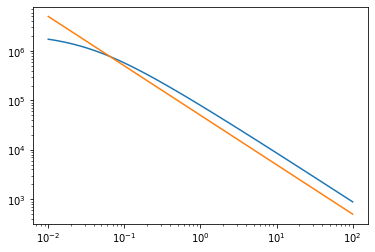

In [35]:
plt.loglog(all_ratios, all_weight_norms)
plt.loglog(all_ratios, 1/all_ratios**1 * 5e4)

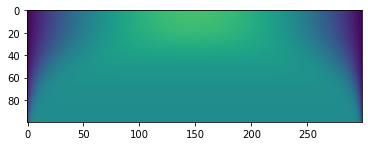

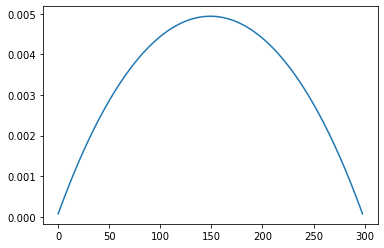

In [36]:
plt.imshow(all_weights, vmin=0, vmax=0.007)
#print(all_weights)
plt.figure()
#plt.plot(np.sum(all_weights, axis=0))
plt.plot(all_weights[0])

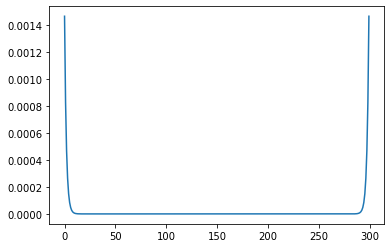

In [37]:
diff_weights = np.abs(np.append(weights, 0) - np.append(0, weights))
plt.plot(diff_weights)

(array([ 1.,  2.,  1.,  7.,  5.,  6.,  8., 18., 19., 17., 17., 14., 15.,
        23., 18., 19., 13., 16., 22., 12.,  7., 12.,  6.,  5.,  6.,  5.,
         2.,  1.,  1.,  1.]),
 array([  1.93898737,   6.87684244,  11.81469752,  16.7525526 ,
         21.69040767,  26.62826275,  31.56611783,  36.50397291,
         41.44182798,  46.37968306,  51.31753814,  56.25539321,
         61.19324829,  66.13110337,  71.06895845,  76.00681352,
         80.9446686 ,  85.88252368,  90.82037875,  95.75823383,
        100.69608891, 105.63394399, 110.57179906, 115.50965414,
        120.44750922, 125.38536429, 130.32321937, 135.26107445,
        140.19892953, 145.1367846 , 150.07463968]),
 <a list of 30 Patch objects>)

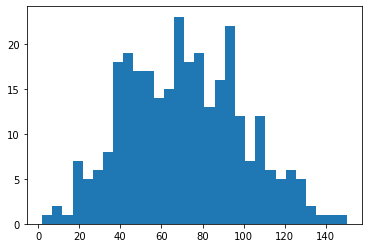

In [38]:
diffs = np.diff(after_gain[0,:,y,x])
plt.hist(diffs, bins=30)
#weighted_avg = 

In [39]:
print(np.sqrt(3.83*5.5 + 2*R**2))

print(np.mean(diffs), np.std(diffs))

18.94901052825714
71.16396803744252 28.608845212715146


In [40]:
weighted_avg = np.sum(weights * diffs) / np.sum(weights)
error = 1. / np.sqrt(np.sum(weights))
print(weighted_avg, error)
#simple_avg = np.mean(diffs)
#print(weighted_avg, simple_avg, 3.82895987, np.median(diffs))

71.20250706115641 1.0


In [41]:
#Get slopes
#after_gain.shape
signal_estimate = (after_gain[:, -1] - after_gain[:, 0]) / (after_gain.shape[1] - 1)
ratio_estimate = (after_gain[:, -1] - after_gain[:, 0])  / R**2
ratio_estimate[ratio_estimate <= 1e-6] = 1e-6
#ratio_estimate[ratio_estimate >= 100] = 100
print(signal_estimate.shape, ratio_estimate.shape)


(44, 416, 72) (44, 416, 72)


In [42]:
N = N_int - 1
j = np.arange(1, N + 1)

ramp_signal_estimate = np.zeros(signal_estimate.shape)
ramp_error = np.zeros(signal_estimate.shape)
diff_array = np.diff(after_gain, axis=1)
noise = np.sqrt(2*R**2 + signal_estimate)
old_bad = np.zeros(diff_array.shape, dtype=bool)

for i in range(len(after_gain)):
    l = np.arccosh(1 + ratio_estimate[i]/N/2)[:, :, np.newaxis]
    weights = -R**-2 * np.exp(l) * (1 - np.exp(-j*l)) * (np.exp(j*l - l*N) - np.exp(l)) / (np.exp(l) - 1)**2 / (np.exp(l) + np.exp(-l*N))
    
    #Find cosmic rays and other anomalies
    z_scores = (diff_array[i] - signal_estimate[i, np.newaxis]) / noise[i, np.newaxis]
    bad = np.abs(z_scores) > 5
    old_bad[i] = bad
    weights[bad.transpose(1,2,0)] = 0
    
    ramp_signal_estimate[i] = np.sum(diff_array[i].transpose(1,2,0) * weights, axis=2) / np.sum(weights, axis=2)
    ramp_error[i] = 1. / np.sqrt(np.sum(weights, axis=2))
    print(i)
   

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43


In [43]:
N = N_int - 1
j = np.arange(1, N + 1)

#signal_estimate = (after_gain[:, -1] - after_gain[:, 0]) / (after_gain.shape[1] - 1)
ratio_estimate = ramp_signal_estimate * N / R**2
ratio_estimate[ratio_estimate <= 1e-6] = 1e-6
noise = np.sqrt(2*R**2 + ramp_signal_estimate)

for i in range(len(after_gain)):
    l = np.arccosh(1 + ratio_estimate[i]/N/2)[:, :, np.newaxis]
    weights = -R**-2 * np.exp(l) * (1 - np.exp(-j*l)) * (np.exp(j*l - l*N) - np.exp(l)) / (np.exp(l) - 1)**2 / (np.exp(l) + np.exp(-l*N))
    
    #Find cosmic rays and other anomalies
    z_scores = (diff_array[i] - ramp_signal_estimate[i, np.newaxis]) / noise[i, np.newaxis]
    bad = np.abs(z_scores) > 5
    print(np.sum(bad != old_bad[i]))
    #weights[bad.transpose(1,2,0)] = 0
    
    #ramp_signal_estimate[i] = np.sum(diff_array[i].transpose(1,2,0) * weights, axis=2) / np.sum(weights, axis=2)
    #ramp_error[i] = 1. / np.sqrt(np.sum(weights, axis=2))
    #print(i)
   

5693
5706
5515
5881
5582
5592
5744
5785
5614
5784
5705
5548
5676
5666
5694
5687
5638
5680
5702
5719
5708
5769
5655
5685
5580
5628
5764
5665
5627
5744
5690
5764
5639
5617
5704
5728
5823
5519
5699
5723
5699
5651
5791
5676


In [54]:
print(old_bad.shape)
np.sum(np.sum(old_bad, axis=1) != 0)

(44, 299, 416, 72)


269344

In [81]:
#cut_bad = old_bad[:,]
plt.imshow(np.sum(old_bad[:,3:,:,9:], axis=(0,1)), vmin=0, vmax=50)

In [84]:
plt.imshow(old_bad[:,3:,:,9:][:,:,44,9])
plt.figure()
plt.plot(after_gain[:,3:,:,9:][:,:,44,9][0])

In [60]:
%matplotlib qt
plt.imshow((np.sum(old_bad, axis=1) != 0)[0])
plt.show()

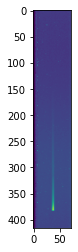

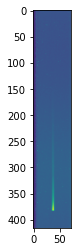

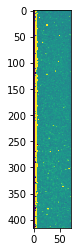

In [44]:
plt.imshow(signal_estimate[0])
plt.figure()
plt.imshow(ramp_signal_estimate[0])
plt.figure()
plt.imshow(signal_estimate[0] - ramp_signal_estimate[0], vmin=-1, vmax=1)

In [45]:
for i in range(diff_array.shape[0]):
    z_scores = (diff_array[i] - ramp_signal_estimate[i, np.newaxis]) / noise[i, np.newaxis]
    print(np.sum(np.abs(z_scores) > 5), diff_array[i].shape)
    #print(np.where(z_scores > 5))
    #print(z_scores)
    #print(i)
    #print(diff_array.shape, z_scores.shape, ramp_signal_estimate.shape, noise.shape)
    #print(diff_array[i,0:4,10,10], ramp_signal_estimate[i,10,10], noise[i,10,10])

101762 (299, 416, 72)
101847 (299, 416, 72)
101539 (299, 416, 72)
101690 (299, 416, 72)
101623 (299, 416, 72)
101643 (299, 416, 72)
101848 (299, 416, 72)
101655 (299, 416, 72)
101344 (299, 416, 72)
101701 (299, 416, 72)
102104 (299, 416, 72)
101639 (299, 416, 72)
101843 (299, 416, 72)
101490 (299, 416, 72)
102020 (299, 416, 72)
101486 (299, 416, 72)
101364 (299, 416, 72)
101655 (299, 416, 72)
101832 (299, 416, 72)
102143 (299, 416, 72)
101935 (299, 416, 72)
101795 (299, 416, 72)
101917 (299, 416, 72)
102035 (299, 416, 72)
101438 (299, 416, 72)
101376 (299, 416, 72)
101849 (299, 416, 72)
102034 (299, 416, 72)
101622 (299, 416, 72)
101754 (299, 416, 72)
101830 (299, 416, 72)
101915 (299, 416, 72)
101532 (299, 416, 72)
101435 (299, 416, 72)
101944 (299, 416, 72)
101690 (299, 416, 72)
101620 (299, 416, 72)
101802 (299, 416, 72)
101455 (299, 416, 72)
101572 (299, 416, 72)
101890 (299, 416, 72)
101824 (299, 416, 72)
101982 (299, 416, 72)
101878 (299, 416, 72)


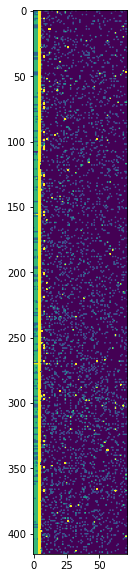

In [46]:
%matplotlib qt
plt.figure(figsize=(10,10))
plt.imshow(np.sum(bad, axis=0), vmin=0, vmax=3)
plt.show()

In [47]:
np.sum(bad, axis=0)[333,52]

3

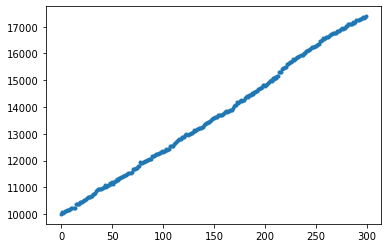

In [48]:
%matplotlib inline
plt.plot(after_gain[-1,:,333,52], '.')

In [49]:
after_gain.shape

(44, 300, 416, 72)

In [85]:
flat = astropy.io.fits.open("jwst_miri_flat_0745.fits")
print(flat)

[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x7f866d34a7b8>, <astropy.io.fits.hdu.image.ImageHDU object at 0x7f866d35db00>, <astropy.io.fits.hdu.image.ImageHDU object at 0x7f866d361320>, <astropy.io.fits.hdu.image.ImageHDU object at 0x7f866d361b70>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x7f866d3675c0>]


In [93]:
%matplotlib qt
plt.imshow(flat[1].data, vmin=0.99, vmax=1.01)
